In [1]:
!pip install underthesea

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import re
from underthesea import word_tokenize

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [4]:
# Hàm đọc và tiền xử lý tệp
def load_and_preprocess(filepath):
    texts, labels = [], []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            match = re.match(r"__label__(\S+)\s+(.*)", line.strip())
            if match:
                labels.append(match.group(1))
                texts.append(match.group(2))
    return texts, labels

# Đọc dữ liệu
train_texts, train_labels = load_and_preprocess('/content/drive/MyDrive/dataset/Train_data.txt')
test_texts, test_labels = load_and_preprocess('/content/drive/MyDrive/dataset/Test_data.txt')

In [5]:
# Tạo DataFrame cho tập train
train_df = pd.DataFrame({'label': train_labels, 'text': train_texts})

# Tạo DataFrame cho tập test
test_df = pd.DataFrame({'label': test_labels, 'text': test_texts})

# Hiển thị 5 dòng đầu của tập train
print("Training DataFrame:")
print(train_df.head())

Training DataFrame:
     label                                               text
0  Du_lich  Theo hành trình tour du lịch Mỹ - Bờ Đông, du ...
1  Nha_dat  mình cần tìm 1 phòng cho khoảng 3 người  quanh...
2  Nha_dat  Cho thuê nhà riêng dt 60m/sàn.  Có 4 phòng ngủ...
3  Nha_dat  Cho thuê nhà ở tầng 4 khép kín, 4/295 Nguyễn K...
4  Mua_sam  ► Crumpler jackpack full photo ► giá : 800.000...


In [6]:
# Hiển thị 5 dòng đầu của tập test
print("Testing DataFrame:")
print(test_df.head())

Testing DataFrame:
                         label  \
0  Mang_internet_va_vien_thong   
1    Kinh_doanh_va_Cong_nghiep   
2                         Sach   
3                      Nha_dat   
4                   Nghe_thuat   

                                                text  
0  🌈 CHÀO NOEL ĐÓN MƯA QUÀ TẶNG . 😍 Nhân dịp Noel...  
1  📢📢📢 KHỞI CÔNG XÂY DỰNG 33 CĂN NHÀ PHỐ LIỀN KỀ ...  
2  Sáng ngày hôm nay, BTC rất vui khi nhận được s...  
3  Cần cho thuê căn hộ chung cư dưới sài đồng đối...  
4  🌈🌈🌈 BÀI DỰ THI CỦA BAN NHẠC OLD MAC DONAL BAND...  


In [7]:
# Thống kê thông tin tập train
print("Training DataFrame Info:")
print(train_df.info())
print("\nTraining Label Distribution:")
print(train_df['label'].value_counts())

# Thống kê thông tin tập test
print("\nTesting DataFrame Info:")
print(test_df.info())
print("\nTesting Label Distribution:")
print(test_df['label'].value_counts())

Training DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   16000 non-null  object
 1   text    16000 non-null  object
dtypes: object(2)
memory usage: 250.1+ KB
None

Training Label Distribution:
label
Nha_dat                         2542
Do_an_va_do_uong                2356
Kinh_doanh_va_Cong_nghiep       2356
Tai_chinh                       1379
Mua_sam                         1169
Du_lich                          881
Chinh_tri                        796
Giao_duc                         697
Nghe_thuat                       609
Mang_internet_va_vien_thong      593
Sach                             415
Con_nguoi_va_xa_hoi              387
Lam_dep_va_the_hinh              283
Nha_va_vuon                      262
Giai_tri                         211
May_tinh_va_thiet_bi_dien_tu     202
Suc_khoe_va_benh_tat             194
Thoi_quen_v

#Tokenization and padding

In [8]:
# Tokenizer
max_vocab_size = 10000
max_sequence_length = 100  # Độ dài tối đa cho mỗi câu
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token='<UNK>')
tokenizer.fit_on_texts(train_texts)  # Chỉ fit trên tập train

# Chuyển văn bản thành chuỗi số
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Padding
train_padded = pad_sequences(train_sequences, maxlen=max_sequence_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_sequence_length, padding='post', truncating='post')


In [9]:
# Encode nhãn
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
test_labels_encoded = label_encoder.transform(test_labels)

# Training and Evaluating Model

In [10]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu
X_train, X_val, y_train, y_val = train_test_split(train_padded, train_labels_encoded, test_size=0.2, random_state=42)

# In số lượng mẫu
print("Số mẫu trong tập huấn luyện:", len(X_train))
print("Số mẫu trong tập validation:", len(X_val))

Số mẫu trong tập huấn luyện: 12800
Số mẫu trong tập validation: 3200


In [11]:
# Số lớp nhãn
num_classes = len(label_encoder.classes_)

# Xây dựng mô hình
model = Sequential([
    Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_sequence_length),
    LSTM(128, return_sequences=False),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 100, 128)              │       1,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (32, 128)                   │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 23)                    │           1,495 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,421,337 (5.42 MB)

 Trainable params: 1,421,335 (5.42 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [14]:
# Huấn luyện mô hình
history = model.fit(
    train_padded, train_labels_encoded,
    validation_split=0.2,
    epochs=100,
    batch_size=32
)

Epoch 1/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.2600 - loss: 2.4235 - val_accuracy: 0.3547 - val_loss: 2.0990
Epoch 2/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.4213 - loss: 1.9654 - val_accuracy: 0.4991 - val_loss: 1.6031
Epoch 3/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5090 - loss: 1.5406 - val_accuracy: 0.5247 - val_loss: 1.4576
Epoch 4/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.5702 - loss: 1.3041 - val_accuracy: 0.6331 - val_loss: 1.1466
Epoch 5/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6582 - loss: 1.0057 - val_accuracy: 0.6791 - val_loss: 0.9599
Epoch 6/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.7264 - loss: 0.7959 - val_accuracy: 0.7503 - val_loss: 0.7780
Epoch 7/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7954 - loss: 0.5925 - val_accuracy: 0.7738 - val_loss: 0.6990
Epoch 8/100
400/400 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.8282 - loss: 0.4503 - val_

In [15]:
# Đánh giá trên tập test
loss, accuracy = model.evaluate(test_padded, test_labels_encoded)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7826 - loss: 2.1064
Test Loss: 2.121048927307129, Test Accuracy: 0.7836461663246155


In [16]:
from sklearn.metrics import classification_report

test_predictions = model.predict(test_padded)
test_predicted_labels = test_predictions.argmax(axis=1)

# Tạo Classification Report
report = classification_report(test_labels_encoded, test_predicted_labels)
print(report)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
              precision    recall  f1-score   support

           0       0.89      0.85      0.87       472
           1       0.86      0.84      0.85       205
           2       0.50      0.20      0.29        20
           3       0.96      0.98      0.97      1425
           4       0.92      0.87      0.90       606
           5       0.97      0.97      0.97       114
           6       0.82      0.93      0.88       460
           7       0.79      0.88      0.83        50
           8       0.47      0.61      0.53        92
           9       0.45      0.54      0.49      1407
          10       0.86      0.90      0.88       181
          11       0.97      0.91      0.94       401
          12       0.93      0.94      0.93       119
          13       0.90      0.88      0.89       762
          14       0.98      0.93      0.95       398
          15       0.96      0.96      0.96      1623
          16       0.81      0.82      0

In [17]:
# Lưu mô hình
model.save('/content/drive/MyDrive/models/text_classification_lstm.h5')

# Lưu tokenizer
import pickle
import os # Import the os module

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname('/content/drive/MyDrive/models/tokenizer.pkl'), exist_ok=True)

with open('/content/drive/MyDrive/models/tokenizer.pkl', 'wb') as f:  # Change 'rb' to 'wb' to write in binary mode
    pickle.dump(tokenizer, f)

# Lưu label encoder
# Create the directory if it doesn't exist
os.makedirs(os.path.dirname('/content/drive/MyDrive/models/label_encoder.pkl'), exist_ok=True)

with open('/content/drive/MyDrive/models/label_encoder.pkl', 'wb') as f:  # Change 'rb' to 'wb' to write in binary mode
    pickle.dump(label_encoder, f)

In [18]:
from tensorflow.keras.models import load_model
import pickle

# Tải mô hình và các thành phần
model = load_model('/content/drive/MyDrive/models/text_classification_lstm.h5')

# Specify the correct path to 'tokenizer.pkl'
with open('/content/drive/MyDrive/models/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

# Specify the correct path to 'label_encoder.pkl'
with open('/content/drive/MyDrive/models/label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)

max_sequence_length = 100

# Tiền xử lý dữ liệu mới
new_texts = ["Cho thuê phòng Cầu Diễn - Nguyên Xá gần ngay các trường  đại học - full đồ tiện ích giá chỉ #3tr -  #3tr3 có ban công Tiện ích: gần ngay ga nhổn, hàng quán tiện ích Liên hệ: 0327066043"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_padded = pad_sequences(new_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Dự đoán
new_predictions = model.predict(new_padded)
predicted_labels = label_encoder.inverse_transform(new_predictions.argmax(axis=1))
print(predicted_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
['Nha_dat']


In [21]:
# Lấy 10 mẫu ngẫu nhiên từ tập test
num_samples = 10
random_indices = np.random.choice(len(test_texts), num_samples, replace=False)
sample_texts = [test_texts[i] for i in random_indices]
sample_labels = [test_labels[i] for i in random_indices]

# Tiền xử lý dữ liệu mẫu
sample_sequences = tokenizer.texts_to_sequences(sample_texts)
sample_padded = pad_sequences(sample_sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Dự đoán
sample_predictions = model.predict(sample_padded)
predicted_labels = label_encoder.inverse_transform(sample_predictions.argmax(axis=1))

# So sánh dự đoán với nhãn thực tế
for i in range(num_samples):
    print(f"Text: {sample_texts[i]}")
    print(f"Predicted Label: {predicted_labels[i]}")
    print(f"Actual Label: {sample_labels[i]}")
    print("-" * 20)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
Text: Xin giới thiệu tới các chế món mới toanh toành tại Quán Xưa - Món Xưa nhé 😘 Set lẩu cua Xưa vừa cho ra mắt đang giảm giá từ 455k còn #389k thôi, đủ cho 4 người ăn no nhé 😮 Ôi nồi nước dùng đặc cua đồng thơm ngon hấp dẫn, mẹt đồ nhúng cũng đầy ăm ắp bắp bò, sườn sụn, đậu với chả cá, giò bò.. xong xì xụp thêm tí bánh đa đỏ nữa phải gọi là ngon quên lối về 👌  ---------------  Quán Xưa 🏠 Địa chỉ: #QuánXưa1 Số 25 Ngõ 59 Láng Hạ, Hà Nội 📞 Hotline đặt bàn #QuánXưa1 :096.220.66.67 🏠 Địa chỉ: #QuánXưa2 Số 60 Tô Hiến Thành, HBT, Hà Nội 📞 Hotline đặt bàn #QuánXưa2: 096.724.32.32
Predicted Label: Do_an_va_do_uong
Actual Label: Do_an_va_do_uong
--------------------
Text: 👉 Gym center đầu tiên và duy nhất được thi công trọn gói theo quy trình xây dựng: ép cọc, đào hầm, đặt móng, đổ sàn với khối lượng sắt thép và bê tông rất nhiều đảm bảo việc tập gym. . 👉 Gym center không còn là 1 phòng tập gym mà theo hướng 1 building hiện đại với thiết bị nội thất đắt t

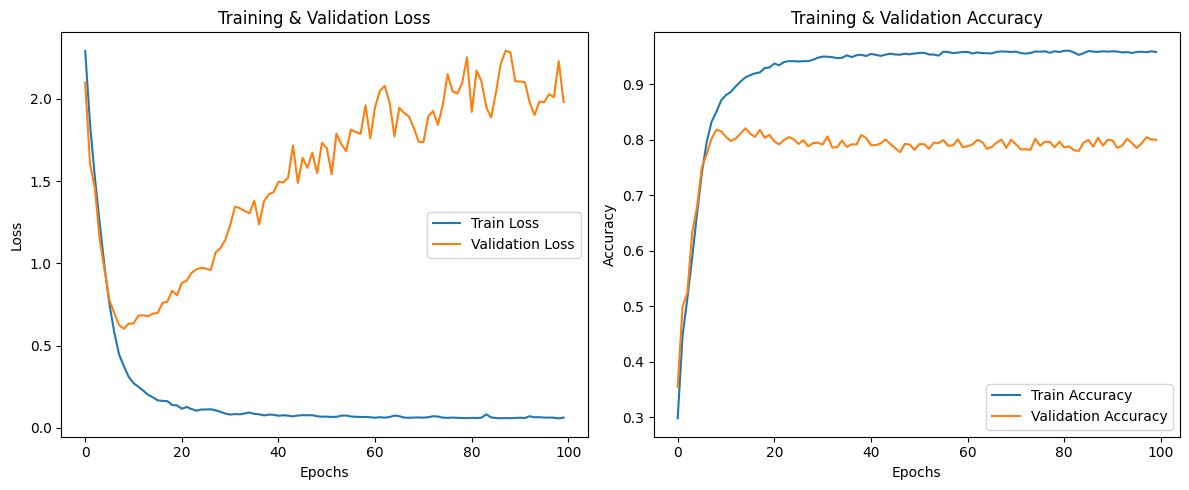

In [19]:
plt.figure(figsize=(12, 5))

# Vẽ đồ thị loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()

# Vẽ đồ thị accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


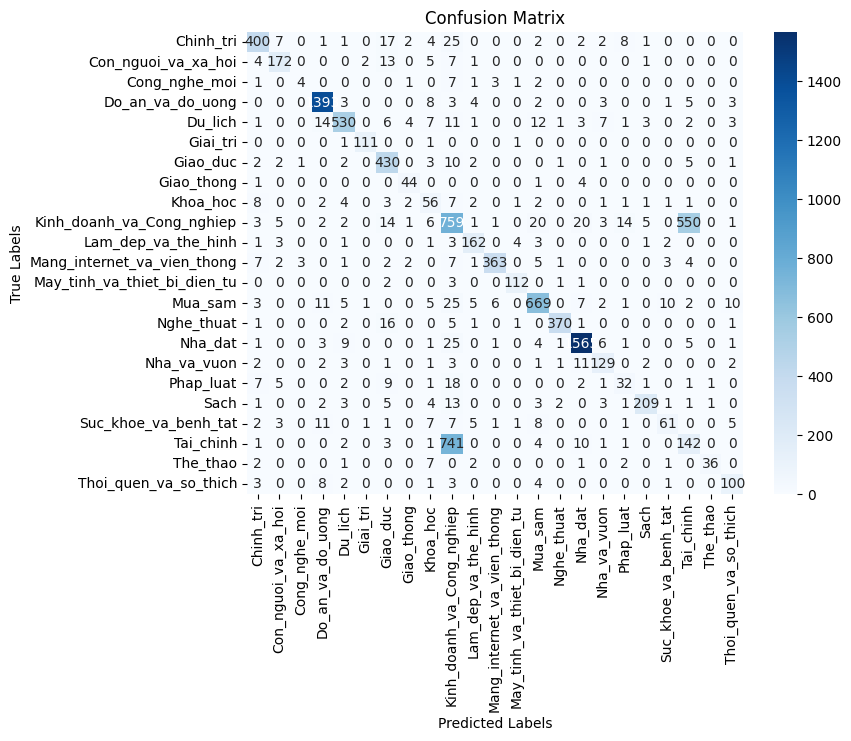

In [20]:
# Tạo ma trận nhầm lẫn
conf_matrix = confusion_matrix(test_labels_encoded, test_predicted_labels)

# Vẽ ma trận nhầm lẫn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()